In [1]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2

#import statments
import numpy as np
import pandas as pd
import io
from tqdm import tqdm
from __future__ import division

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 24})
%config InlineBackend.rc = {}
%matplotlib inline

# Creating SFR histories

## creating Gladders

In [208]:
def SFR_Gladders(t,t0,tau):
    return np.exp(-(np.log(t)-t0)**2/(2*tau)**2)/(t*np.sqrt(2*np.pi*tau**2))

In [209]:
single_SFR_history_Gladders=[]
time_sample=np.arange(0.1,14,0.01)

# prefactor 75 so that SFR=1.5 M_sun/year today
for t in time_sample:
    single_SFR_history_Gladders.append(SFR_Gladders(t,1.539,0.574)*75)

In [210]:
len(time_sample)

1390

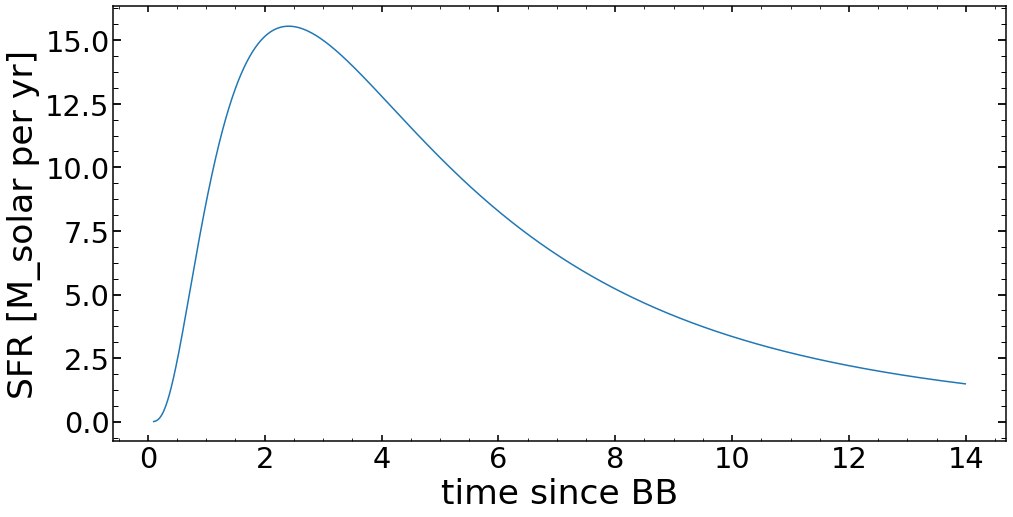

In [211]:
plt.figure(figsize=(16,8))
plt.plot(time_sample,single_SFR_history_Gladders)
plt.xlabel('time since BB')
plt.ylabel('SFR [M_solar per yr]')

In [377]:
np.random.seed(1400)
t0_sample=np.random.normal(1.539,0.4,100)
tau_sample=np.random.normal(0.574,0.4,100)


many_SFR_history_Gladders=[]
for i in range(len(t0_sample)):
    single_SFR_history_Gladders=[]
    for t in time_sample:
        single_SFR_history_Gladders.append(75*SFR_Gladders(t,t0_sample[i],tau_sample[i]))

    many_SFR_history_Gladders.append(single_SFR_history_Gladders)
    
many_SFR_history_Gladders=np.array(many_SFR_history_Gladders)

In [378]:
many_SFR_history_Gladders.shape

(100, 1390)

In [379]:
total_SFR_at_one_moment_in_time_Gladders=[]
for t in range(len(time_sample)):
    total_SFR_at_one_moment_in_time_Gladders.append(np.sum(many_SFR_history_Gladders[:,t]))
    
total_SFR_at_one_moment_in_time_Gladders=np.array(total_SFR_at_one_moment_in_time_Gladders)

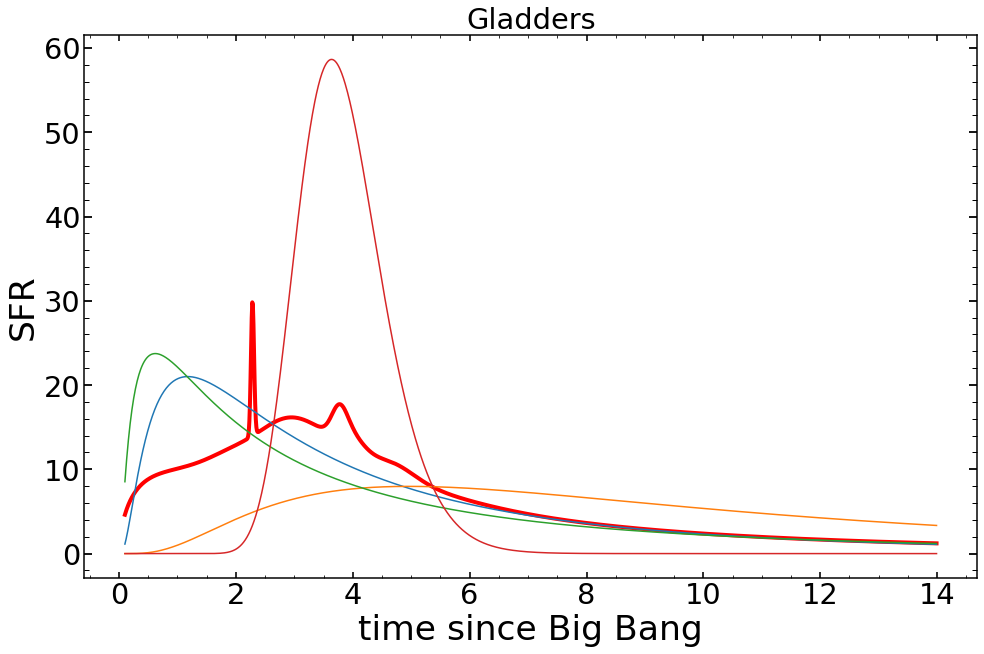

In [380]:
plt.figure(figsize=(16,10))
plt.plot(time_sample,total_SFR_at_one_moment_in_time_Gladders/100,color='red',lw=4)
plt.plot(time_sample,many_SFR_history_Gladders[12])
plt.plot(time_sample,many_SFR_history_Gladders[15])
plt.plot(time_sample,many_SFR_history_Gladders[52])
plt.plot(time_sample,many_SFR_history_Gladders[85])
plt.xlabel('time since Big Bang')
plt.ylabel('SFR')
plt.title('Gladders')


## creating stochastic

In [381]:
# this is the package that actually generates the SFR histories
from DELCgen import *

In [382]:
# amplitude
A=1
#slope on the short time scales
a_low=2
#slope on the long time scales - by definition in our work this is set at 0
a_high=0
# intercept/offset: adds constant to the final output; not used it this work
c=0

In [396]:
# set frequency of the break
v_bend_Example1=1.0/(100)
# simulate the SFR history - we simulate very long history to not be senitive to potential aliasing (basically edge effects)
# and to fully probe stochastic process
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example1,a_low,a_high,0),RedNoiseL=1,aliasTbin=1,tbin = 1,length=30000,randomSeed=1234)


In [397]:
sample_of_random_integers=[]
for i in range(100):
    sample_of_random_integers.append(np.random.randint(0,30000-many_SFR_history_Gladders.shape[1]))

In [398]:
stochastic_components=[]
for i in range(100):
    stochastic_components.append(0.3*delc.flux[sample_of_random_integers[i]:sample_of_random_integers[i]+1390])

In [399]:
many_SFR_history_stochatic=10**(stochastic_components+np.log10(total_SFR_at_one_moment_in_time_Gladders/100))

total_SFR_at_one_moment_in_time_stochatic=[]
for t in range(len(time_sample)):
    total_SFR_at_one_moment_in_time_stochatic.append(np.sum(many_SFR_history_stochatic[:,t]))
    
total_SFR_at_one_moment_in_time_stochatic=np.array(total_SFR_at_one_moment_in_time_stochatic)


In [400]:
stochastic_Gladders_ratio=total_SFR_at_one_moment_in_time_stochatic[-1]/total_SFR_at_one_moment_in_time_Gladders[-1]
total_SFR_at_one_moment_in_time_stochatic=total_SFR_at_one_moment_in_time_stochatic/stochastic_Gladders_ratio
many_SFR_history_stochatic=many_SFR_history_stochatic/stochastic_Gladders_ratio

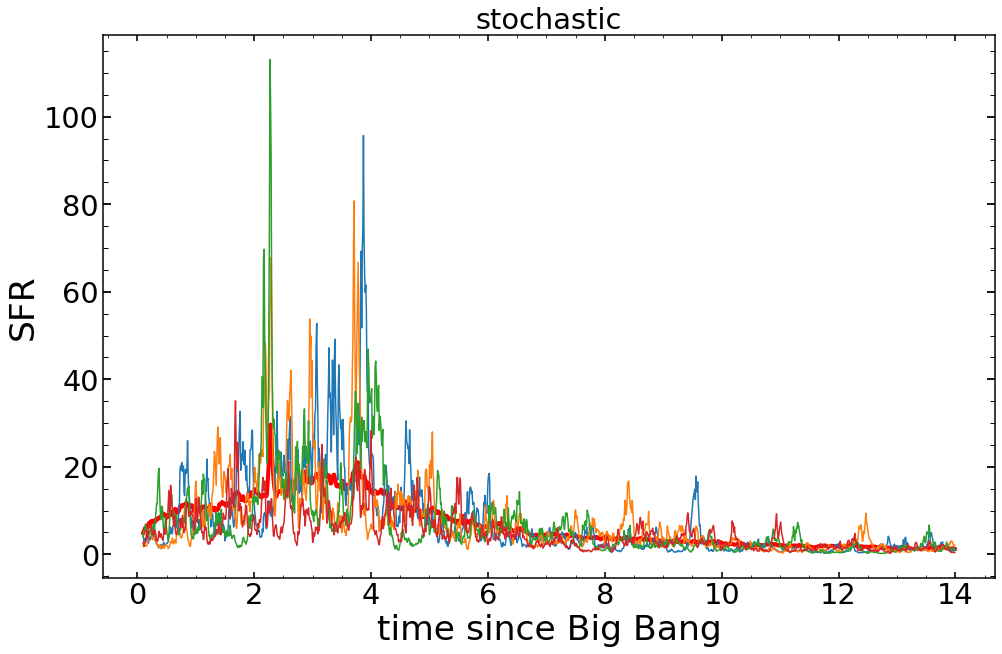

In [401]:
plt.figure(figsize=(16,10))
plt.plot(time_sample,total_SFR_at_one_moment_in_time_stochatic/100,color='red',lw=4)
plt.plot(time_sample,many_SFR_history_stochatic[0])
plt.plot(time_sample,many_SFR_history_stochatic[15])
plt.plot(time_sample,many_SFR_history_stochatic[52])
plt.plot(time_sample,many_SFR_history_stochatic[85])
plt.xlabel('time since Big Bang')
plt.ylabel('SFR')
plt.title('stochastic')

## comparison of two approaches

(-0.5, 2)

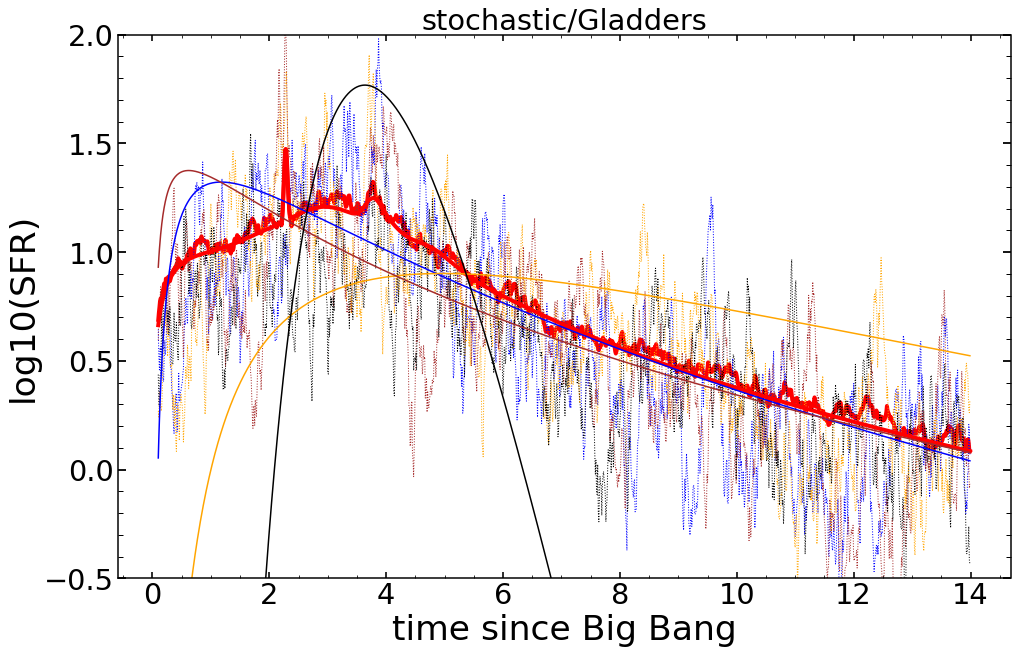

In [402]:
plt.figure(figsize=(16,10))
plt.plot(time_sample,np.log10(total_SFR_at_one_moment_in_time_stochatic/100),color='red',lw=4)
plt.plot(time_sample,np.log10(many_SFR_history_stochatic[0]),color='blue',lw=1,ls=':')
plt.plot(time_sample,np.log10(many_SFR_history_stochatic[15]),color='orange',lw=1,ls=':')
plt.plot(time_sample,np.log10(many_SFR_history_stochatic[52]),color='brown',lw=1,ls=':')
plt.plot(time_sample,np.log10(many_SFR_history_stochatic[85]),color='black',lw=1,ls=':')

plt.plot(time_sample,np.log10(total_SFR_at_one_moment_in_time_Gladders/100),color='red',lw=4)
plt.plot(time_sample,np.log10(many_SFR_history_Gladders[12]),color='blue')
plt.plot(time_sample,np.log10(many_SFR_history_Gladders[15]),color='orange')
plt.plot(time_sample,np.log10(many_SFR_history_Gladders[52]),color='brown')
plt.plot(time_sample,np.log10(many_SFR_history_Gladders[85]),color='black')


plt.xlabel('time since Big Bang')
plt.ylabel('log10(SFR)')
plt.title('stochastic/Gladders')

plt.ylim(-0.5,2)

In [403]:
one_time_step_in_yr=0.01 * 10**9
# average galaxies will have this mass on the end
np.log10(np.sum(0.01 * 10**9 *total_SFR_at_one_moment_in_time_stochatic/100))

10.984865735923195

In [404]:
total_masses_stochastic=[]
for i in range(100):
    total_masses_stochastic.append(np.log10(np.sum(0.01 * 10**9 *many_SFR_history_stochatic[i])))
    
total_masses_stochastic=np.array(total_masses_stochastic)

total_masses_Gladders=[]
for i in range(100):
    total_masses_Gladders.append(np.log10(np.sum(0.01 * 10**9 *many_SFR_history_Gladders[i])))
    
total_masses_Gladders=np.array(total_masses_Gladders)

/Users/nevencaplar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/Users/nevencaplar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


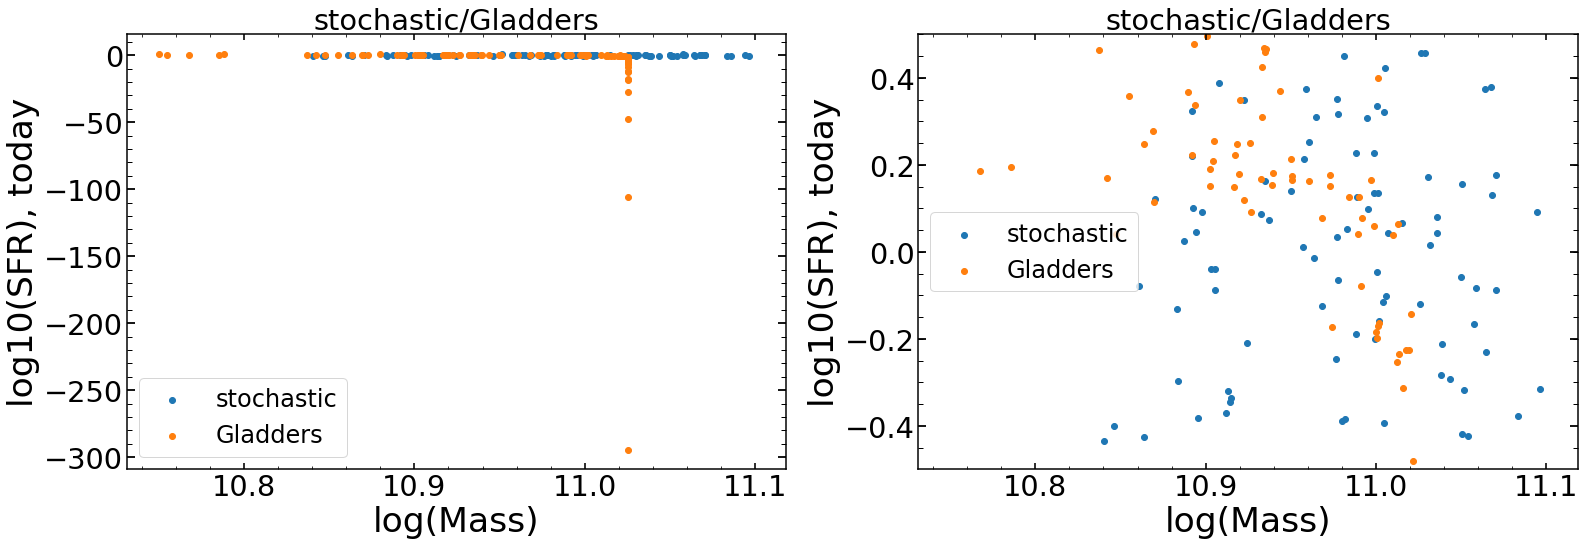

In [425]:
plt.figure(figsize=(26,8))
plt.subplot(121)
plt.scatter(total_masses_stochastic,np.log10(many_SFR_history_stochatic[:,-1]),label='stochastic')
plt.scatter(total_masses_Gladders,np.log10(many_SFR_history_Gladders[:,-1]),label='Gladders')
plt.legend()
plt.xlabel('log(Mass)')
plt.ylabel('log10(SFR), today')
plt.title('stochastic/Gladders')

plt.subplot(122)
plt.scatter(total_masses_stochastic,np.log10(many_SFR_history_stochatic[:,-1]),label='stochastic')
plt.scatter(total_masses_Gladders,np.log10(many_SFR_history_Gladders[:,-1]),label='Gladders')
plt.ylim(-0.5,0.5)
plt.legend()
plt.xlabel('log(Mass)')
plt.ylabel('log10(SFR), today')
plt.title('stochastic/Gladders')

In [429]:
narrow_mass_range_stochastic=many_SFR_history_stochatic[(total_masses_stochastic>10.85) & (total_masses_stochastic<11)]
narrow_mass_range_Gladders=many_SFR_history_Gladders[(total_masses_Gladders>10.85) & (total_masses_Gladders<11)]

In [430]:
np.std(np.log10(narrow_mass_range_stochastic[:,-1]))

0.29958085158891928

In [431]:
np.std(np.log10(narrow_mass_range_Gladders[:,-1]))

0.15709429326835905

In [436]:
narrow_mass_range_stochastic_averaged=[]
for i in range(len(narrow_mass_range_stochastic)):
    narrow_mass_range_stochastic_averaged.append(np.mean(narrow_mass_range_stochastic[i][-100:]))
    
    
narrow_mass_range_Gladders_averaged=[]    
for i in range(len(narrow_mass_range_Gladders)):
    narrow_mass_range_Gladders_averaged.append(np.mean(narrow_mass_range_Gladders[i][-100:]))

In [439]:
np.std(np.log10(narrow_mass_range_stochastic_averaged))

0.17280963898265139

In [440]:
np.std(np.log10(narrow_mass_range_Gladders_averaged))

0.15621113893957539

In [ ]:
# no change in Gladders!!!!!!